In [2]:
import torch
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
from torch import nn
import seaborn as sn

In [3]:
class ConvolutionalModel(nn.Module):
  def __init__(self):
      super().__init__()
      self.convlayers = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=(3, 3)),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(16, 32, kernel_size=(3, 3)),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

      )

      self.linearlayers = nn.Sequential(
          nn.Linear(1152, 256),
          nn.ReLU(),
          nn.Linear(256, 10)
      )

  def forward(self, x):
      x = self.convlayers(x)
      x = torch.flatten(x, 1)
      return self.linearlayers(x)

In [16]:
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/DeepLearning/Video2ProgDinamica'

CATEGORIES = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

prep_transform = T.Compose([
                    T.ToTensor(),
                    T.Normalize(
                        (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)
                    )
                  ])

tensor_train = CIFAR10(DATA_DIR, train=True, download=False,
                         transform=prep_transform)
tensor_test = CIFAR10(DATA_DIR, train=False, download=False,
                         transform=prep_transform)

In [10]:
batch_size = 64
train_loader = DataLoader(tensor_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tensor_test, batch_size=batch_size, shuffle=False)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando na {device}")

Rodando na cuda


In [5]:
convmodel = ConvolutionalModel().to(device)

In [7]:
def train(model, dataloader, loss_func, optimizer):
  model.train()
  cumloss = 0.0

  for imgs, labels in dataloader:
    imgs, labels = imgs.to(device), labels.to(device)
    
    optimizer.zero_grad()

    pred = model(imgs)

    loss = loss_func(pred, labels)
    loss.backward()
    optimizer.step()

    cumloss += loss.item()

  return cumloss / len(dataloader)

def validate(model, dataloader, loss_func):
  model.eval()
  cumloss = 0.0

  with torch.no_grad():
    for imgs, labels in dataloader:
      imgs, labels = imgs.to(device), labels.to(device)

      pred = model(imgs)
      loss = loss_func(pred, labels)
      cumloss += loss.item()

  return cumloss / len(dataloader)

In [6]:
loss_func2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.SGD(convmodel.parameters(), lr=0.001)

In [12]:
epochs = 51
conv_train_losses = []
conv_test_losses = []
for t in range(epochs):
  train_loss = train(convmodel, train_loader, loss_func2, optimizer2)
  conv_train_losses.append(train_loss)
  if t % 10 == 0:
    print(f"Epoch: {t}; Train Loss: {train_loss}")
  test_loss = validate(convmodel, test_loader, loss_func2)
  conv_test_losses.append(test_loss)

Epoch: 0; Train Loss: 2.0109978513339595
Epoch: 10; Train Loss: 1.5652045281341924
Epoch: 20; Train Loss: 1.3702690046461647
Epoch: 30; Train Loss: 1.2559306682528133
Epoch: 40; Train Loss: 1.1673400333470396
Epoch: 50; Train Loss: 1.0932297316353645


In [13]:
def plot_losses(losses):
  fig = plt.figure(figsize=(13, 5))
  ax = fig.gca()
  for loss_name, loss_values in losses.items():  
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize="16")
  ax.set_xlabel("Iteration", fontsize="16")
  ax.set_ylabel("Loss", fontsize="16")
  ax.set_title("Loss vs iterations", fontsize="16");


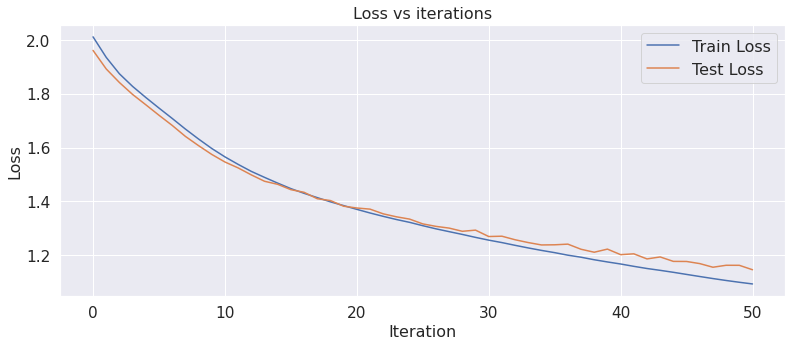

In [24]:
conv_losses = {"Train Loss": conv_train_losses, "Test Loss": conv_test_losses}
plot_losses(conv_losses)

def evaluate_accuracy(model, dataloader, classes, verbose=True):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes} 

def make_confusion_matrix(model, loader, n_classes):
  confusion_matrix = torch.zeros(n_classes, n_classes, dtype=torch.int64)
  with torch.no_grad():
    for i, (imgs, labels) in enumerate(loader):
      imgs = imgs.to(device)
      labels = labels.to(device)
      outputs = model(imgs)
      _, predicted = torch.max(outputs, 1)
      for t, p in zip(torch.as_tensor(labels, dtype=torch.int64).view(-1), 
                      torch.as_tensor(predicted, dtype=torch.int64).view(-1)):
        confusion_matrix[t, p] += 1
  return confusion_matrix

In [30]:
conv_confusion_matrix = evaluate_accuracy(convmodel, test_loader, CATEGORIES)

In [33]:
plt.figure(figsize=(12, 12))
sn.set(font_scale=1.4)

<Figure size 864x864 with 0 Axes>